### Случайный лес, бустинг и bias-variance tradeoff

### План семинара:

1. Случайный лес
2. Bias-variance decomposition
3. Градиентный бустинг

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.evaluate import bias_variance_decomp
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (10, 8)

## Случайный лес <a name="randomforest"></a>

Вспомним, из каких шагов складывается обучение случайного леса. Алгоритм из $ N$ деревьев, выглядит следующим образом:


Для каждого $n = 1, \dots, N$: <br>
1. Сгенерировать выборку $ X_n$ с помощью бутстрапа; <br>
2. Построить решающее дерево $ b_n$ по выборке $ X_n$: <br>
— по заданному критерию выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки <br>
— дерево строится, пока в каждом листе не более $ n_\text{min}$ объектов или другому критерию останова <br>
— при каждом разбиении сначала выбирается $ m$ случайных признаков из $ n$ исходных, 
и оптимальное разделение выборки ищется только среди них.

Так, при построении каждого дерева при созданию нового узла случайным образом выбираем набор признаков для разбиения. Таким образом, мы снизим дисперсию итоговой модели, поскольку уменьшаем скоррелированность деревьев. 

Итоговый классификатор имеет вид $ a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, где $b_i$ - одно из деревьев (базовый алгоритм). Для задачи кассификации мы выбираем класс через правило голосования большинства, а в задаче регрессии — берем средний прогноз.


Возьмем датасет для задачи многоклассовой классификации и обучим для ее решения случайный лес:

In [2]:
X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)


rfc = RandomForestClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        rfc, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.084
Average bias: 0.111
Average variance: 0.031


Для сравнения, посчитаем усредненные смещение и дисперсию для более простого алгоритма (решающего дерева):

In [6]:
tree = DecisionTreeClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.079
Average bias: 0.111
Average variance: 0.047


Сравните ошибку, смещение и дисперсию двух данных алгоритмов.

**Вопросы на обсуждение**:
1. Что такое out-of-bag ошибка?
2. Может ли случайный лес переобучиться?

1. **Out-of-bag-ошибка** - это усредненная ошибка на непопавших в выборку объектах по всему итоговому алгоритму.  

Вспомним, что при обучении случайного леса каждое дерево строится на подвыборке, бустрапированной из исходной обучающей выборки. Соответственно, будут такие наблюдения, которые ни разу не попадут ни в одну из подвыборок. Данные объекты можно использовать для валидации при оценке качества алгоритма. Для этого, воспользуемся при инициализации модели параметром `oob_score`. 

In [7]:
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=42) # oob_score=True говорит, что мы хотим использовать out-of-bag score для оценки качества
model.fit(X_train, y_train)
model.oob_score_

0.4113436302180531

GitHub Copilot: `oob_score_` в `RandomForestRegressor` относится к "Out-of-bag" (OOB) оценке, которая является методом оценки производительности случайного леса. Каждое дерево в случайном лесу обучается на разных подмножествах обучающих данных, выбранных с заменой, что означает, что некоторые наблюдения могут быть выбраны несколько раз, в то время как другие - ни разу. Наблюдения, которые не были выбраны для обучения конкретного дерева, называются "out-of-bag" наблюдениями. 

`oob_score_` вычисляет среднюю ошибку прогнозирования для каждого наблюдения на деревьях, которые не видели этого наблюдения во время своего обучения. Это дает некоторую оценку производительности модели на новых данных и может быть альтернативой кросс-валидации.

Ваш `oob_score_` равен примерно 0.411. Это означает, что ваша модель объясняет примерно 41.1% вариации в данных, которые она не видела во время обучения. Это не идеально, но это говорит о том, что модель имеет некоторую предсказательную способность. Однако, в зависимости от контекста и важности задачи, вам может потребоваться модель с более высоким `oob_score_`.

2. Попробуем ответить на вопрос, используя датасет по предсказанию степени диабета (в диапазоне вещественных чисел 25 - 346) для задачи регрессии, построив случайный лес для разного количества деревьев.

100%|██████████| 49/49 [00:02<00:00, 18.22it/s]


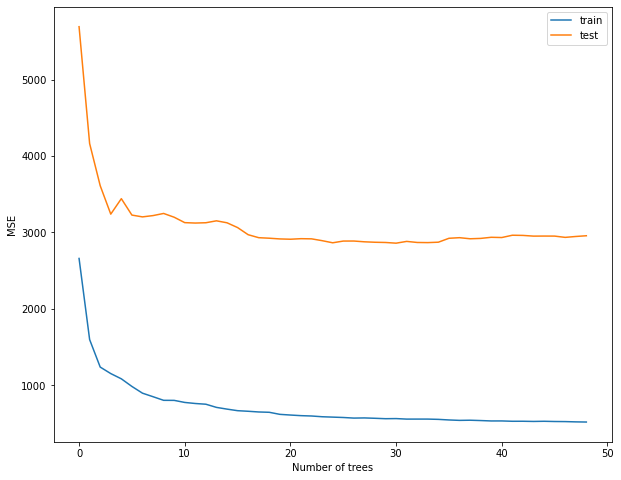

In [8]:
train_mse, test_mse = [], []
n_trees = 50

for i in tqdm(range(1, n_trees)):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlabel('Number of trees')
plt.legend();

Видно, что графики напоминают геометрическое распределение, и что при определенном значении количества деревьев ошибка начинает убывать уже слабее. Какой вывод можно сделать с точки зрения переобучения при увеличении числа деревьев? 

Попробуйте провести эксперименты относительно переобучения случайного леса, поменяв другие параметры, например, `max_depth`. 

GitHub Copilot: Верно, увеличение количества деревьев в случайном лесу обычно не приводит к переобучению. Это связано с тем, что случайные леса работают путем усреднения прогнозов множества деревьев, обученных на разных подмножествах данных. Это делает их более устойчивыми к шуму в обучающих данных и менее склонными к переобучению.

Однако, это не означает, что можно безразлично увеличивать количество деревьев. После определенного количества деревьев, улучшение производительности модели становится незначительным, а время обучения и использование ресурсов продолжают расти. Поэтому обычно есть оптимальное количество деревьев, которое зависит от конкретной задачи и данных.

Но изменение других параметров может на тесте в какой-то момент начать увеличиватть ошибку, там надо выбирать оптимальную сложность модели

## Bias - variance decomposition <a name="decompose"></a>

Ошибка любой модели складывается из 3 факторов: сложности выборки, схожести обученной модели с истинной зависимостью с ответами в выборке и свойств семейства, к которому относится выбранная модель. Между этими факторами существует баланс, при котором увеличение одной составляющей приводит к уменьшению другой. 

Любую функцию ошибки можно разложить на три компоненты, описывающие сложность и качество построенного алгоритма: **смещение** (bias), **дисперсию** (variance) и **шум** (noise). 

Рассмотрим разложение на смещение и дисперсию на примере задачи регрессии. 

Пусть задана некоторая выборка $(x_i, y_i)$, при $i = 1, ..., N$, прогнозы для каждого i-го объекта обозначим как $\hat y_i$. Рассмотрим уже известную нам квадратичную функцию потерь: $Q(a, y) = (y - \hat y)^2$. Математическое ожидание среднеквадратичной ошибки можно представить как:

$$\mathbb{E}[y - \hat{y}]^2 = bias^2 + variance + noise,$$

где

|||||
|---|---|:---:|---|
|смещение|$\mathrm{bias}$|$\mathbb{E}(\hat{y}) - y$|ошибка из-за простоты модели (отклонение среднего прогноза модели от истинных ответов)|
|дисперсия|$\mathrm{variance}$|$\mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2$| ошибка из-за сложности модели (разброс прогнозов модели относительно ее среднего прогноза|
|шум|$\mathrm{noise}$|$\mathbb{E}[y - \mathbb{E}(y)]^2$|ошибка идеальной модели (из-за наличия шума в данных)|


Разбор разложения MSE на смещение и дисперсию в общем виде можно посмотреть в лекции или [тут](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf) в общем виде. 

Давайте рассмотрим пример решения задачи регресси на данных с наличием нелинейных связей - например, через сигмоиду, как предложено [здесь](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/comment-page-1/). 

Сгенерируем случайную выборку:

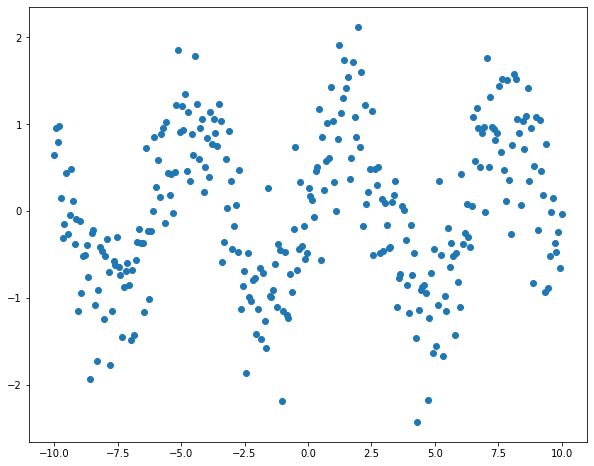

In [13]:
N = 300
X = np.linspace(-10, 10, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.5, N).reshape(-1, 1)
plt.scatter(X, y);

Давайте посмотрим на модели с разной сложностью и проанализируем их с точки зрения смещения и дисперсии. Построим модель линейной регрессии на признаке X, а потом попробуем усложнять эту модель через добавление новых полиноминальных признаков с разной степенью.

In [14]:
def train_polinomial_reg(degree=1):
    polynomial = PolynomialFeatures(degree)
    new_features = polynomial.fit_transform(X)
    polreg = LinearRegression()
    polreg.fit(new_features, y)
    preds = polreg.predict(new_features)
    return preds

# Линейная регрессия
linreg = train_polinomial_reg(1)

# Регрессия на полиноминальных признаках со степень 5
polinoms_5 = train_polinomial_reg(5)

# Регрессия на полиноминальных признаках со степень 15
polinoms_15 = train_polinomial_reg(15)

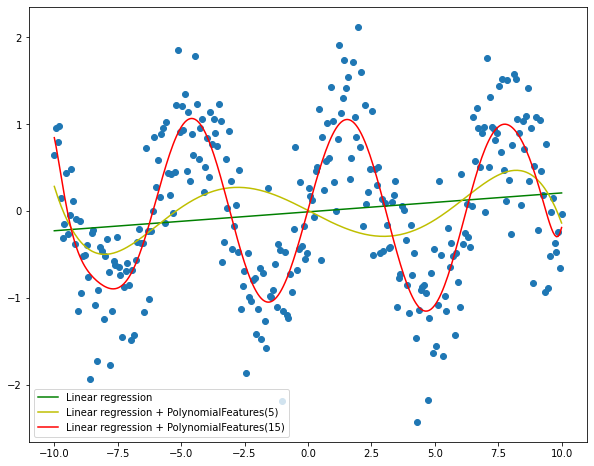

In [15]:
plt.scatter(X, y)
plt.plot(X, linreg, label='Linear regression', c='g')
plt.plot(X, polinoms_5, label='Linear regression + PolynomialFeatures(5)', c='y')
plt.plot(X, polinoms_15, label='Linear regression + PolynomialFeatures(15)', c='r')
plt.legend();

Как можно увидеть на графиках, простые модели недообучаются, сложные модели - переобучаются. Простая модель имеет высокую дисперсию и малое смещение, и в данном случая простая линейная регрессия (с полиномом первой степени) плохо подходит для описания целевой переменной. В то же время, более сложные модели по мере увеличения степени полинома имеет меньшую дисперсию, но большее смещение. 

|||||
|---|---|:---:|---|
|**model's complexity**|**bias**|**variance**
|simple|high|low
|complex|low| high


При этом, на обучающей выборке ошибка MSE будет, действительно, убывать по мере увеличения степени полинома:

In [17]:
[mean_squared_error(x, y) for x in [linreg, polinoms_5, polinoms_15]]

[0.768270385986397, 0.7115437401820734, 0.258606347157613]

Но если мы поделим выборку на train и test, и будем оценивать ошибку на тесте, то увидим переобучение при возрастающей сложности алгоритма:

In [18]:
train_size = 200 

def get_preds_on_test(degree=1, train_size=200):
    polynomial = PolynomialFeatures(degree)
    new_features = polynomial.fit_transform(X)
    polreg = LinearRegression()
    X_train, y_train = new_features[:train_size], y[:train_size]
    X_test, y_test = new_features[train_size:], y[train_size:]
    polreg.fit(X_train, y_train)
    preds = polreg.predict(X_test)
    return preds

linreg = get_preds_on_test(1, 200)
polinoms_5 = get_preds_on_test(5, 200)
polinoms_15 = get_preds_on_test(15, 200)
y_test = y[train_size:]


[mean_squared_error(x, y_test) for x in [linreg, polinoms_5, polinoms_15]]

[1.0933774760621082, 19102.4759198038, 2389514688942.811]

<img src='http://neerc.ifmo.ru/wiki/images/1/18/Bias-Variance-Tradeoff.png'>

Подводя небольшой итог - нам приходится искать компромисс между между простотой и сложностью модели, между недообучением и переобучением. С точки зрения смещения и дисперсии, обычно наилучшее качество достигается при средних значениях обоих.

## Бустинг

**Ключевая идея** градиентного бустинга - строим набор базовых алгоритмов, каждый из которых исправляет ошибку предыдущих. Так же, как и для дерева или случайного леса, можем использовать градиентый бустинг и для задачи регрессии, и для задачи классификации.

#### Задачи по теории  <a name="tasks"></a>

Дана выборка из четырех наблюдений. На ней построены два дерева:

|$$x_{i}$$|$$y_{i}$$|
|---|---|
|1|6|
|2|6|
|3|12|
|4|18|

<img src='task1.png' width=400>

Давайте построим бэггинг. Первому дереву достались наблюдения 1, 1, 2 и 3. Второму дереву - наблюдения 2, 3, 4 и 4. 

**Задача 1.** Будем строить прогнозы в каждом листе, минимизируя сумму квадратов ошибок. 

1. Какие прогнозы внутри обучающей выборки мы получим с помощью такого леса?
2. Сколько деревьев имеет смысл посадить, чтобы получить хорошие вневыборочные прогнозы по четырем наблюдениям?

GitHub Copilot: 1. Прогнозы внутри обучающей выборки, полученные с помощью такого леса, будут равны среднему значению целевой переменной для наблюдений в каждом листе. Для первого дерева, у нас есть два листа: один с наблюдениями 1 и 2 (со значениями целевой переменной 6 и 6), и другой с наблюдением 3 (со значением целевой переменной 12). Таким образом, прогнозы для этих наблюдений будут 6 и 12 соответственно. Для второго дерева, у нас есть два листа: один с наблюдениями 2 и 3 (со значениями целевой переменной 6 и 12), и другой с наблюдением 4 (со значением целевой переменной 18). Таким образом, прогнозы для этих наблюдений будут 9 и 18 соответственно.

2. Количество деревьев, которое имеет смысл посадить для получения хороших вневыборочных прогнозов, зависит от многих факторов, включая сложность данных и степень шума в них. В общем случае, увеличение количества деревьев может улучшить вневыборочные прогнозы до определенного предела, после которого дополнительные деревья могут не принести значительного улучшения. В данном случае, поскольку у нас всего четыре наблюдения, даже одного дерева может быть достаточно для получения хороших прогнозов. Однако, для более сложных наборов данных, может потребоваться больше деревьев.

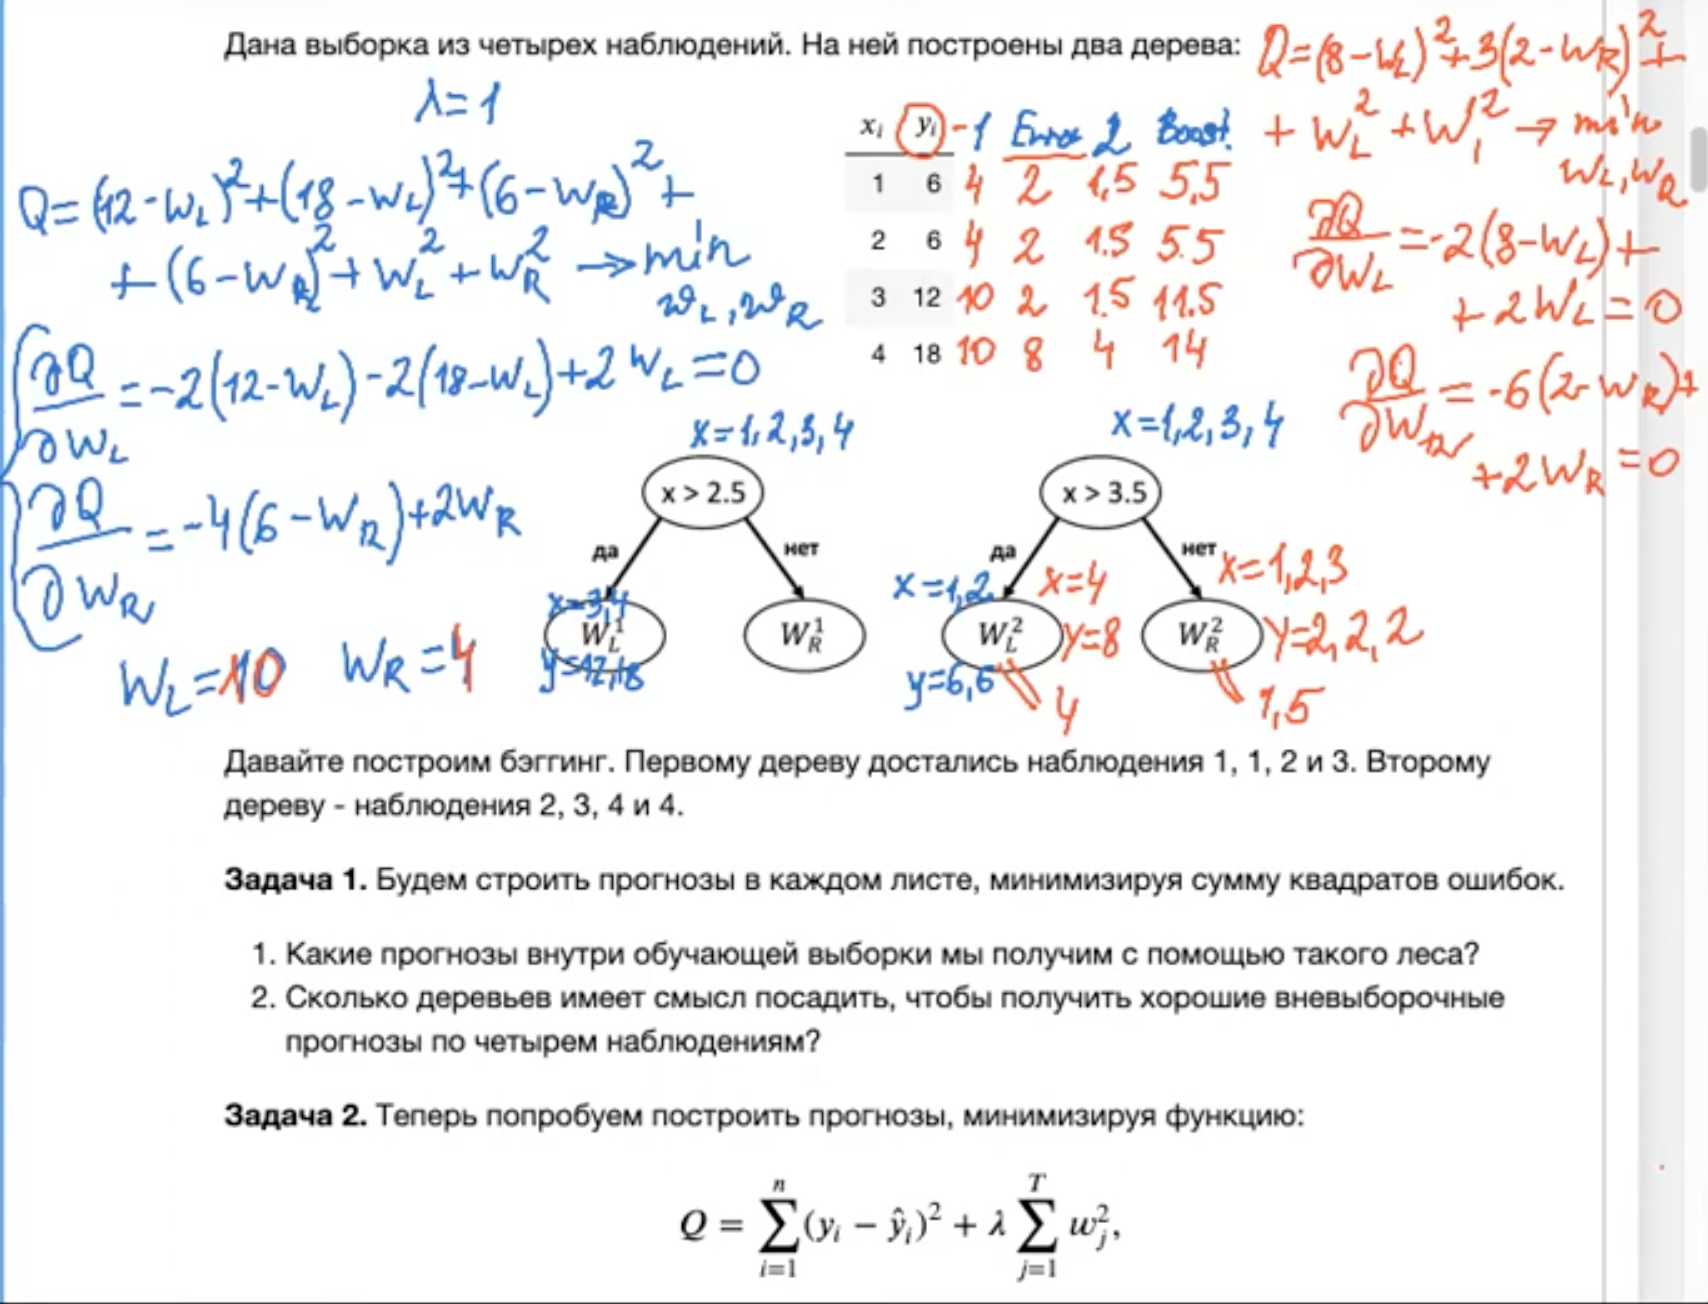



**Задача 2.** Теперь попробуем построить прогнозы, минимизируя функцию:

$$Q = \sum_{i=1}^n (y_i - \hat y_i)^2 + \lambda \sum_{j=1}^T w_j^2,$$

где $y_i$ — прогнозируемое значение для $i$-го наблюдения, $n$ — количество наблюдений, $w_j$ — прогноз в $j$-ом листе, $T$ — количество листов на дереве.

1. Какие прогнозы внутри обучающей выборки мы получим с помощью такого леса? 
2. Построим бустинг с темпом обучения $\mu$ и такой же функцией потерь. Какие прогнозы внутри обучающей выборки мы получим при $\mu = 0.5$ и $\lambda = 1$? 
3. Сколько деревьев для бэггинга имеет смысл посадить, чтобы получить хорошие вневыборочные прогнозы по четырем наблюдениям? Для бустинга?

GitHub Copilot: 1. Прогнозы внутри обучающей выборки, полученные с помощью такого леса, будут определяться минимизацией функции потерь, которая включает в себя как сумму квадратов ошибок, так и регуляризационный член, штрафующий за большие значения прогнозов в листьях. Это может привести к тому, что прогнозы будут меньше, чем если бы мы минимизировали только сумму квадратов ошибок.

2. При использовании бустинга с темпом обучения 0.5 и λ = 1, каждое последующее дерево будет пытаться исправить ошибки предыдущего дерева, умноженные на темп обучения. Это может привести к более медленной сходимости, но также может помочь предотвратить переобучение.

3. Количество деревьев, которое имеет смысл посадить для бэггинга или бустинга, зависит от многих факторов, включая сложность данных, степень шума и выбранную функцию потерь. В общем случае, увеличение количества деревьев может улучшить вневыборочные прогнозы до определенного предела, после которого дополнительные деревья могут не принести значительного улучшения. Однако, бустинг может быть более склонен к переобучению при увеличении количества деревьев, поскольку каждое дерево пытается исправить ошибки предыдущего.
GitHub Copilot: В вашем случае, количество деревьев, которое имеет смысл посадить для бэггинга или бустинга, будет зависеть от конкретных данных, с которыми вы работаете, и от того, как эти данные реагируют на увеличение сложности модели.

Если вы заметите, что увеличение количества деревьев приводит к улучшению вневыборочных прогнозов, то может быть полезно продолжать увеличивать количество деревьев до тех пор, пока улучшения не станут незначительными или пока не начнет увеличиваться ошибка на тестовом наборе данных (что может указывать на переобучение).

Однако, если увеличение количества деревьев не приводит к значительному улучшению вневыборочных прогнозов, или если ошибка на тестовом наборе данных начинает увеличиваться, то может быть лучше остановиться на меньшем количестве деревьев.

В случае бустинга, каждое дерево пытается исправить ошибки предыдущего, поэтому увеличение количества деревьев может привести к переобучению, особенно если темп обучения высок. В этом случае, может быть полезно использовать меньшее количество деревьев или меньший темп обучения.


In [14]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pylab as plt
%pylab inline
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from time import time
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


#### Градиентный бустинг в sklearn  <a name="sklearn"></a>


Сегодня поработаем с датасетом `Customer Personality Analysis` с платформы Kaggle. Подробнее про данные можно прочитать [тут](https://www.kaggle.com/imakash3011/customer-personality-analysis).

Набор данных содрежит доступную информацию по клиентам и их покупательскому поведению. Сбор таких данных помогает бизнесу лучше понимать своих клиентов и облегчает им изменение продуктов в соответствии с конкретными потребностями, поведением и проблемами разных типов клиентов.

На основе социально-демографических признаков и интересных статистик по истории покупок продуктов и участию в предыдущих маркетинговых акциях попробуем для каждого клиента предсказать, участвовал ли он в последней маркетинговой акции или нет:

`Response: 1 if customer accepted the offer in the last campaign, 0 otherwise`

Эта задача часто используется в маркетинге, чтобы заранее предсказывать, насколько новая промоакция будет успешной для выбранного сегмента пользователей.

Посмотрим на датасет:

In [4]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


На этом шаге нужно отдельно провести EDA: посмотреть, сколько у нас наблюдений и признаков, какого типа данных каждый признак; проверить наличие пропусков, выбросов и обработать их; сделать препроцессинг признаков - например, закодировать и нормализовать их; можно сгенерировать новые признаки на основе исходных и сделать обзор признаков и другое.

Все эти шаги очень важны, но т.к. в этот раз хотим сфокусироваться на ансамблях моделей, отберем только пару признаков из датасета, обработаем пропущенные значения, и перейдем к обучению моделей для их сравнения.

In [5]:
X = df[['Year_Birth', 'Income', 'Kidhome', 'Recency', 'MntWines', 
        'MntSweetProducts', 'NumWebPurchases', 'NumStorePurchases', 
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
        'AcceptedCmp5']]
y = df['Response']
y.value_counts(normalize=True)

0    0.850893
1    0.149107
Name: Response, dtype: float64

In [6]:
X.isna().sum()

Year_Birth            0
Income               24
Kidhome               0
Recency               0
MntWines              0
MntSweetProducts      0
NumWebPurchases       0
NumStorePurchases     0
AcceptedCmp1          0
AcceptedCmp2          0
AcceptedCmp3          0
AcceptedCmp4          0
AcceptedCmp5          0
dtype: int64

In [7]:
for col in tqdm(X.columns):
    X[col] = X[col].fillna(np.mean(X[col]))

100%|██████████| 13/13 [00:00<00:00, 1912.25it/s]


Воспользуемся имплементацией градиентного бустинга из sklearn. Обратите внимание, доступны отдельно модели для классификации и регрессии - `GradientBoostingClassifier` и `GradientBoostingRegressor`.

Посмотрим на часть наиболее важных параметров для инициализации модели градиентного бустинга (для классификации). Как можно заметить, очень похоже на случайный лес:

```
loss='deviance' - функция потерь,
learning_rate=0.1 - скорость обучения,
n_estimators=100 - количество деревьев,
subsample=1.0 - доля наблюдений для обучения каждого базового алгоритма,
criterion='friedman_mse' - информационный критерий,
min_samples_split=2 - минимальное количество наблюдений, чтобы продолжать разбиение выборки в текущем узле,
min_samples_leaf=1 - минимальное количество наблюдений в листе,
max_depth=3 - максимальная глубина каждого базового алгоритма,
min_impurity_decrease=0.0 - сплит узла будет сделан, только если удалось достигнуть большего или равного увеличения значения по метрике степени упорядоченности выборки (impurity)
по формуле N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)
min_impurity_split=None - то же самое, только задаем само значение метрики,
max_features=None - максимальное количество признаков, используемое для сплита,
verbose=0 - показывать ли в выводе ячейки каждую итерацию обучения
```

Для разминки, построим градиентный бустинг с 10 деревьями. Поменяем только критерий и выведем значения функции ошибки для каждой итерации, остальные параметры оставим дефолтными. Обратите внимание, что в задаче классификации композиция базовых алгоритмов будет выдавать вещественные числа, которые по смыслу являются оценками логита - логарифм отношения вероятности положительного класса к вероятности отрицательного класса, поэтому используем `mse`. 

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
model = GradientBoostingClassifier(
    criterion='squared_error',
    n_estimators=10,
    random_state=42,
    verbose=1)

round(cross_val_score(model, X, y, cv=3, scoring='f1').mean(), 2)

      Iter       Train Loss   Remaining Time 
         1           0.7974            0.07s
         2           0.7699            0.05s
         3           0.7482            0.03s
         4           0.7311            0.03s
         5           0.7152            0.02s
         6           0.7023            0.02s
         7           0.6897            0.01s
         8           0.6794            0.01s
         9           0.6699            0.00s
        10           0.6603            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7951            0.03s
         2           0.7641            0.02s
         3           0.7408            0.02s
         4           0.7207            0.02s
         5           0.7056            0.01s
         6           0.6889            0.01s
         7           0.6750            0.01s
         8           0.6634            0.01s
         9           0.6522            0.00s
        10           0.6424            0.00s
      It

0.25

Сравним, как ведут себя градиентный бустинг и случайный лес (частный случай бэггинга) с ростом числа базовых алгоритмов.

В **случайном лесе** все деревья настраиваются на различные выборки из одного и того же распределения. При этом, некоторые из них могут переобучиться, но усреднение позволяет это ослабить (для некоррелированных алгоритмов диперсия композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов). Если $N$ достаточно велико, то последующие увеличение числа `n_estimators` не позволят улучшить качество модели.

В **градиентном бустинге** при достаточно большом $N$ появляется риск переобучения, так как увеличение числа базовых алгоритмов `n_estimators` будет продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, в то же время уменьшая обобщающую способность итоговой модели.

Нарисуем графики качества в зависимости от числа деревьев для случайного леса на тренировочной и тестовой выборках. Также, нарисуем график времени обучения алгоритма от числа деревьев.

In [20]:
from time import time

def get_model_scores(selected_model, n_list=np.arange(10, 250, 20), learning_rate=0.1):
    
    acc_train = []
    acc_test = []
    time_list = []

    n_list = n_list

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

    for n in tqdm(n_list):
        model = selected_model(n_estimators=n, random_state=42)
        # у RF нет параметра learning_rate
        if type(model) == type(GradientBoostingClassifier()):
            model.learning_rate = learning_rate 
        t_start = time()
        model.fit(X_train, y_train)
        t_end = time()
        time_list.append(t_end - t_start)

        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        acc_train.append(accuracy_score(y_train, preds_train))
        acc_test.append(accuracy_score(y_test, preds_test))
        
    return acc_train, acc_test, time_list

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.24it/s]


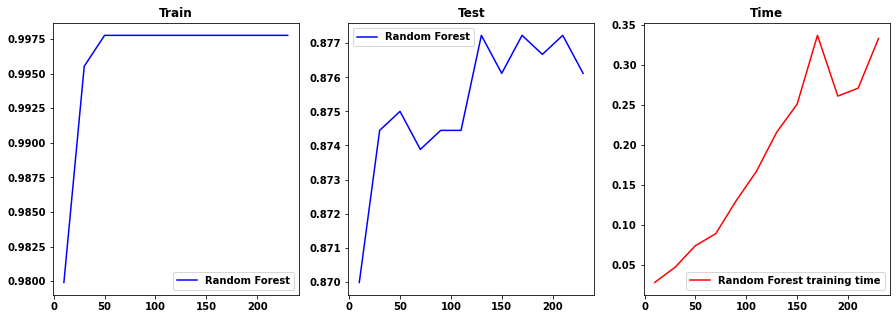

In [21]:
acc_train, acc_test, time_list = get_model_scores(RandomForestClassifier)

params = {1: [acc_train, 'Random Forest', 'Train'], 
          2: [acc_test, 'Random Forest', 'Test'], 
          3: [time_list, "Random Forest training time", 'Time']}

def plot_graphs(params):
    figure(figsize=(15, 5))
    color = 'b'
    n_list = np.arange(10, 250, 20)
    for num in range(1, 4):
        plt.subplot(1, 3, num)
        if num == 3:
            color = 'r'
        plot(n_list, params[num][0], label=params[num][1], c=color)
        plt.legend()
        plt.title(params[num][2])

plot_graphs(params)

Отметим, что с качество случайного леса растет и на обучающей, и на тестовой выборке, но если на обучающей мы довольно быстро достигаем числа деревьев, после которого качество уже не растет, то на тестовых данных видим более интересную, "зубчатую" картинку. Время обучения с увеличением числа деревьев тоже ожидаемо увеличивается. 

Теперь посмотрим, как меняется качество бустинга при увеличении числа деревьев.

Постройте аналогичные графики, но для градиентного бустинга.

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.15it/s]


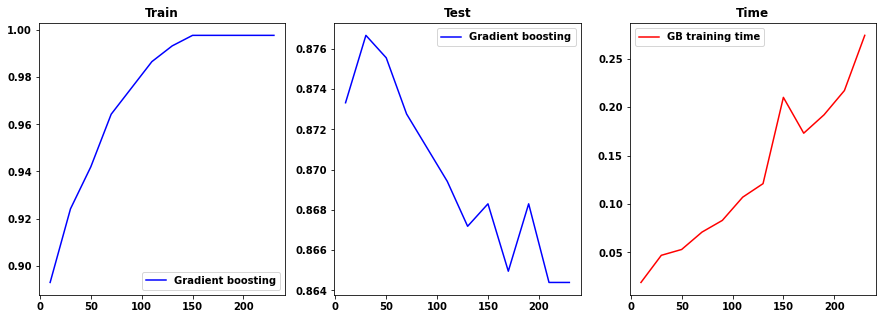

In [22]:
acc_train, acc_test, time_list = get_model_scores(GradientBoostingClassifier)
params = {1: [acc_train, 'Gradient boosting', 'Train'], 
          2: [acc_test, 'Gradient boosting', 'Test'], 
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

Видно, что у градиентный бустинг переобучился: его ошибка на обучающей выборке постоянно уменьшается, а ошибка на тестовых данных увеличивается, начиная с некоторого числа деревьев (так как на графике показано убывание точности (accuracy), равносильно сказать, что качество на тестовых данных падает). На train качество растет, на test падает - перед нами типичный случай переобучения. 

Значит, надо остановиться на некотором числе деревьев, с наименьшей ошибкой на графике на тестовых данных.

Также, бороться с переобучением можно с помощью выбора очень простого базового алгоритма или
снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta b_n(x).$$

$\eta$ - это наш learning_rate. Его уменьшение замедлит обучение по сравнению с бэггингом, но зато позволит побороть переобучение, хотя не до конца - оно останется при увеличении количества базовых алгоритмов для фиксированного $\eta$.

Давайте поменяем значение с 0.1 на 0.01 и обучим градиентный бустинг еще раз:

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.89it/s]


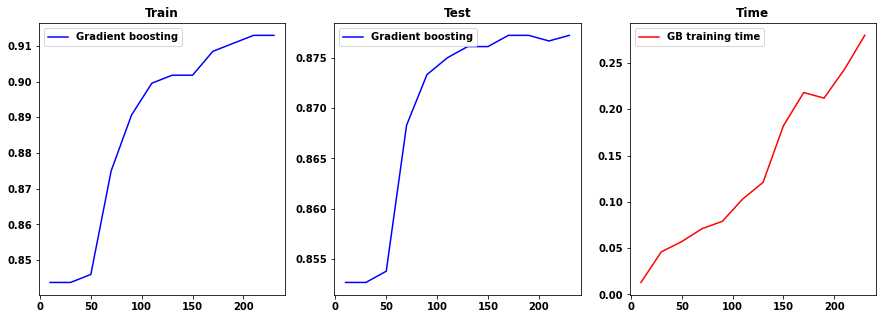

In [23]:
acc_train, acc_test, time_list = get_model_scores(GradientBoostingClassifier, learning_rate=0.01)
params = {1: [acc_train, 'Gradient boosting', 'Train'], 
          2: [acc_test, 'Gradient boosting', 'Test'], 
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

Давайте попробуем улучшить качество, вспомним, что можно подбирать наилучшие гиперпараметры у модели через `GridSearchCV`. Подберите `max_features`, `max_depth` и `min_samples_leaf` для градиентного бустинга с его помощью.

In [24]:
from sklearn.model_selection import GridSearchCV

Дефолтные параметры c accuracy 0.87 у нас были такие:

In [25]:
model = GradientBoostingClassifier(
    criterion='mse',
    n_estimators=10,
    random_state=42
)

model.max_features, model.max_depth, model.min_samples_leaf, model.n_estimators

(None, 3, 1, 10)

In [26]:
%%time 

parameters = {'max_features': [3, 5, 10, None], 
              'max_depth': np.arange(1, 10, 2), 
              'min_samples_leaf': np.arange(1, 20, 5)}

model = model = GradientBoostingClassifier(criterion='mse', n_estimators=10, random_state=42)
clf = GridSearchCV(model, parameters)
clf.fit(X, y)

print(f'Параметры лучшей модели по качеству на test: {clf.best_params_}')
print(f'Лучшая модель: {clf.best_estimator_}')
print(f'Лучшая Accuracy: {round(clf.best_score_, 2)}', end='\n\n')

Параметры лучшей модели по качеству на test: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 16}
Лучшая модель: GradientBoostingClassifier(criterion='mse', max_depth=5, max_features=10,
                           min_samples_leaf=16, n_estimators=10,
                           random_state=42)
Лучшая Accuracy: 0.88

Wall time: 14.4 s


#### Take away:

Случайный лес и градиентный бустинг - это мощные ансамблевые алгоритмы, которые при должной настройке параметров показывают хорошее качество работы. Но надо помнить, что градиентный бустинг имеет склонность к переобучению с увеличением числа деревьев, и аккуратно подбирать число деревьев для алгоритма.

#### Дополнительные материалы для искушенных:
    
1. [Документация sklearn по GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
2. [Открытый курс машинного обучения. Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/)
3. [Пишем XGBoost с нуля. Часть 1](https://habr.com/ru/company/vk/blog/438560/)
4. [Пишем XGBoost с нуля. Часть 2](https://habr.com/ru/company/vk/blog/438562/)
5. [Gradient Boosting explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

Дополнительные материалы:

1) [Блог Александра Дьяконова. Анализ малых данных. Смещение (bias) и разброс (variance)](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/comment-page-1/)